In [ ]:
!pip install transformers opencv-python matplotlib -q --upgrade git+https://github.com/facebookresearch/segment-anything.git 


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 44.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 53.2 MB/s eta 0:00:00
ERROR: Operation cancelled by user


In [ ]:
import sys
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip

--2023-05-26 09:59:59--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 204.246.191.18, 204.246.191.33, 204.246.191.17, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|204.246.191.18|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt  13%[=>                  ] 328.02M  91.0MB/s    eta 24s    ^C
--2023-05-26 10:00:03--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.96.20, 52.217.93.36, 3.5.8.122, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.96.20|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip.1’

annotations_trainva 100%[===================>] 241.19M  4

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import gc
import cv2
import torch
import torchvision
from PIL import Image
import requests

def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)
    del ann
    gc.collect()

def crop_masks(image, anns):
  cropped_images= []
  sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
  for ann in sorted_anns:
    x, y, w, h = ann['bbox']
    cropped_image = image[x:(y+h), x:(x+w)]
    cropped_images.append(cropped_image)
  return cropped_images

def show_box(box, ax):
    x0, y0, w, h = box[0], box[1], box[2], box[3]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))  

def show_boxes_on_image(raw_image, anns):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    for ann in anns:
      show_box(ann['bbox'], plt.gca())
    plt.axis('on')
    plt.show()





**1. Input**

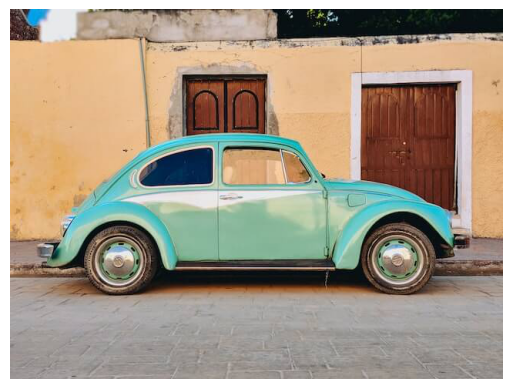

In [ ]:
image_url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/car.jpg"
image = np.asarray(Image.open(requests.get(image_url, stream=True).raw).convert("RGB"))
plt.axis('off')
plt.imshow(image)

In [ ]:
!mkdir images
!wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg
image1 = cv2.imread('images/dog.jpg')


--2023-05-26 00:14:48--  https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99846 (98K) [image/jpeg]
Saving to: ‘images/dog.jpg’

dog.jpg             100%[===================>]  97.51K  --.-KB/s    in 0.01s   

2023-05-26 00:14:48 (6.66 MB/s) - ‘images/dog.jpg’ saved [99846/99846]

(480, 640, 3)
(534, 800, 3)


**1.1 Automatic Mask Generation using SamAutomaticMaskGenerator**

In [ ]:
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(
    model = sam,
    points_per_side = 32,
    points_per_batch = 64,
    pred_iou_thresh = 0.95,
    stability_score_thresh = 0.95,
    stability_score_offset = 1.0,
    box_nms_thresh = 0.7,
    crop_n_layers = 0,
    crop_nms_thresh = 0.7,
    crop_overlap_ratio = 100 / 1500,
    crop_n_points_downscale_factor = 1,
    point_grids = None,
    min_mask_region_area = 0,
    output_mode = "binary_mask",
)

In [ ]:
masks = mask_generator.generate(image)

**2. Segmentation**

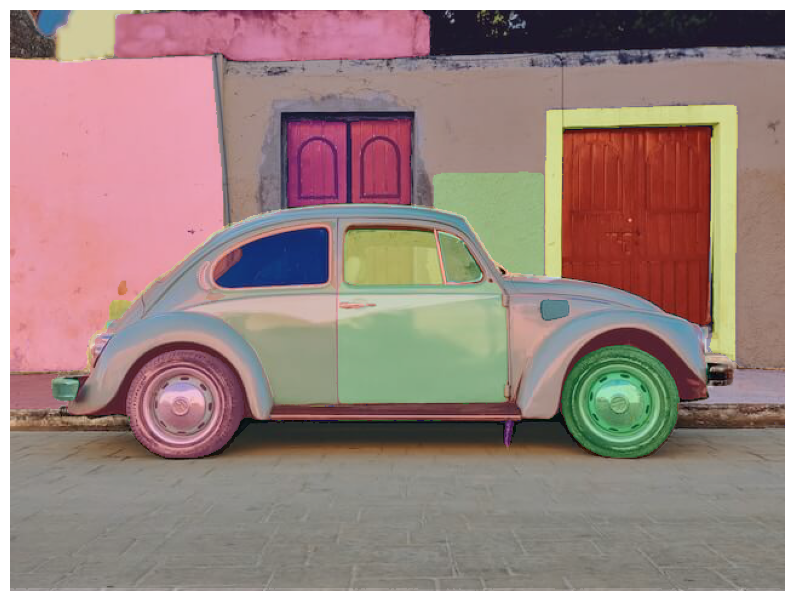

In [ ]:
#Mask Generation
plt.figure(figsize=(10,10))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

**3. Cropping Masks**

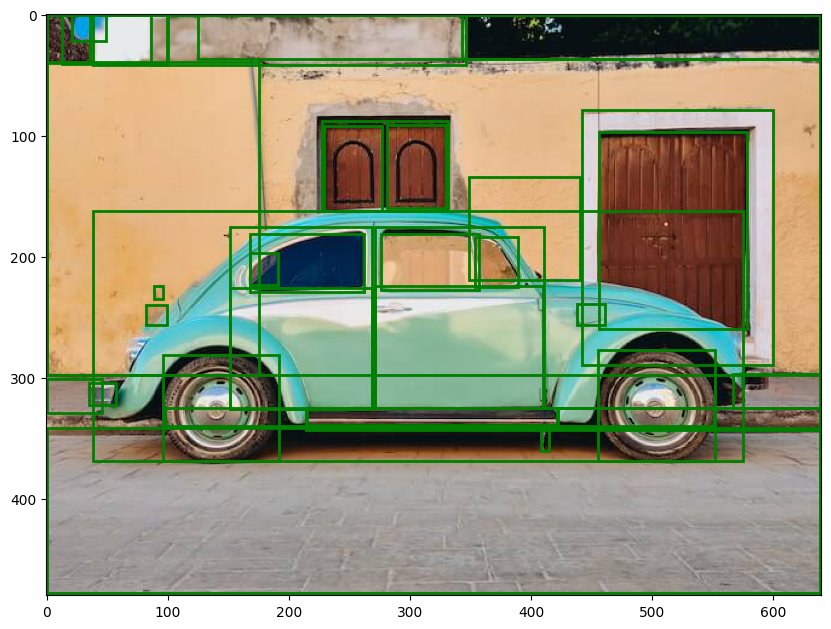

In [ ]:
sorted_anns = sorted(masks, key=(lambda x: x['area']), reverse=True)
show_boxes_on_image(image, sorted_anns)

In [ ]:
images= crop_masks(image,masks)

**4. Openclip Labelling**

In [ ]:
from transformers import pipeline
classifier = pipeline(model="openai/clip-vit-large-patch14")

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


**4.1 COCO Labels

In [ ]:
from pycocotools.coco import COCO

dataDir='..'
dataType=''
annFile='annotations/instances_val2017.json'

In [ ]:
!ls
!unzip annotations_trainval2017.zip

annotations_trainval2017.zip  anns  sample_data
Archive:  annotations_trainval2017.zip
  inflating: annotations/instances_train2017.json  
  inflating: annotations/instances_val2017.json  
  inflating: annotations/captions_train2017.json  
  inflating: annotations/captions_val2017.json  
  inflating: annotations/person_keypoints_train2017.json  
  inflating: annotations/person_keypoints_val2017.json  


In [ ]:
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.88s)
creating index...
index created!


In [ ]:
# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))


COCO categories: 
person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush



In [ ]:
print(nms)

['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [ ]:
PIL_image = Image.fromarray(images[0])
classifier(PIL_image,candidate_labels=nms)

NameError: ignored